# Playing with rank computation

In [1]:
from scipy.sparse import rand, save_npz, load_npz
import numpy as np
import tensorflow as tf
from parallelrank import find_rank

#assert len(tf.config.list_physical_devices('GPU')) > 0

matrix = rand(1000, 1000, density=0.0001, format='csr', dtype=np.int8)
matrix.data[:] = 1

### Simple comparison

In [5]:
%%time
rank = tf.linalg.matrix_rank(matrix.todense(), tol=1e-5).numpy()
print(rank)

89
Wall time: 482 ms


In [3]:
%%time
rank = find_rank(matrix.indptr, matrix.indices, matrix.shape[1], matrix.shape[0])
print(rank)

89
Wall time: 1.36 s


### Generate dataset to compare algorithms

In [31]:
def create_density(side, density_side):
    return (density_side / side) ** 2

In [2]:
sides = [10, 100, 500, 1000, 5000, 10_000]
density_side = 10
repititions = 10

for side in sides:
    for i in range(repititions):
        density = create_density(side, density_side)
        matrix = rand(side, side, density=density, format='csr', dtype=np.int8)
        matrix.data[:] = 1
        save_npz("data/side_{}/matrix_{}.npz".format(side, i), matrix)

In [5]:
from time import perf_counter

sides = [10, 100, 500, 1000, 5000, 10_000]
repititions = 10

def test_algorithm(sides, repititions, algorithm_func):
    algorithm_time = []

    for side in sides:
        total_time = 0
        for i in range(repititions):
            matrix = load_npz("data/side_{}/matrix_{}.npz".format(side, i))
            time_start = perf_counter()
            algorithm_func(matrix)
            time_stop = perf_counter()
            total_time += time_stop-time_start
        algorithm_time.append(total_time / repititions)

    return np.array(algorithm_time)

In [6]:
algorithm_time = test_algorithm(
    sides, 
    repititions, 
    lambda matrix: find_rank(matrix.indptr, matrix.indices, matrix.shape[1], matrix.shape[0])
)

In [7]:
tf_time = test_algorithm(
    sides, 
    repititions, 
    lambda matrix: tf.linalg.matrix_rank(matrix.todense(), tol=1e-5).numpy()
)

In [8]:
np.save("data/tf_time.npy", tf_time)

In [14]:
np.save("data/algorithm_time_v0.1.npy", algorithm_time)

### Compare algorithms

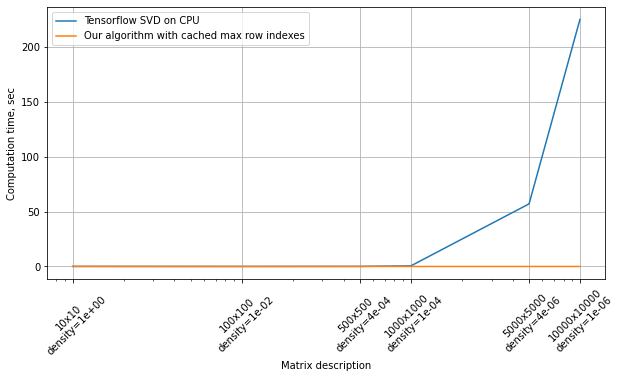

In [46]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 5))
plt.plot(sides, np.load("data/tf_time.npy"), label="Tensorflow SVD on CPU")
plt.plot(sides, np.load("data/algorithm_time_v0.1.npy"), label="Our base algorithm")
plt.plot(sides, np.load("data/algorithm_time_v0.2.npy"), label="Our algorithm with cached max row indexes")
plt.xscale('log')
plt.xticks(
    sides, 
    list(map(lambda x: "{}x{}\ndensity={:.0e}".format(
        str(x), 
        str(x), 
        create_density(x, density_side)
    ), sides)), 
    rotation=45
)
plt.legend()
plt.xlabel("Matrix description")
plt.ylabel("Computation time, sec")
plt.grid()
plt.show()